# postcovid dataset preprocessing
### Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pandas as pd
import numpy as np
from liriscat.dataset.preprocessing_utilities import *
from liriscat.utils import utils
import torch
utils.set_seed(0)

CUDA is not available. Skipping CUDA seed setting.


### Load and merge dataset

In [3]:
raw_data = pd.read_csv('../1-raw_data/postcovid.csv', encoding="ISO-8859-15", low_memory=False)

raw_data = raw_data.drop(columns=['Unnamed: 0.2', 'Unnamed: 0',
       'Unnamed: 0.1', 'start_time', 'qr',
       'qr_compl'])

raw_data =  raw_data.rename(columns={"skill_id": "dimension_id"})
raw_data.head()


,dimension_id,user_id,item_id,correct,UX_answer,result,answers,itemnaireId,userIdAndCreationDate
0,{9},0,3,1.0,2,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q10', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
1,{9},0,12,3.0,4,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q11', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
2,{9},0,20,2.0,3,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q12', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
3,{9},0,27,3.0,4,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q13', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
4,{9},0,34,1.0,2,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q14', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...


### Split rows with several dimensions

In [6]:
raw_data['dimension_id'] = raw_data['dimension_id'].apply(lambda x: set(map(int, x.strip('{}').split(', '))))
df_expanded = raw_data.explode('dimension_id').reset_index(drop=True)
df_expanded.head()

AttributeError: 'set' object has no attribute 'strip'

### Early stats

In [5]:
print(len(df_expanded))
all_data = df_expanded.dropna(subset=['user_id','item_id','correct','dimension_id'])
print(len(all_data))

51690
51690


In [6]:
stat_unique(all_data, None)
stat_unique(all_data, ['user_id', 'item_id'])
stat_unique(all_data, 'user_id')
stat_unique(all_data, 'item_id')
stat_unique(all_data, 'dimension_id')

Total length: 51690
Number of unique [user_id,item_id]: 37390
Number of unique user_id: 917
Number of unique item_id: 184
Number of unique dimension_id: 18


### Clean Nan values

In [7]:
cleaned_data = all_data.dropna(subset=['user_id','item_id','correct','dimension_id'], axis='index')
cleaned_data

,dimension_id,user_id,item_id,correct,UX_answer,result,answers,itemnaireId,userIdAndCreationDate
0,9,0,3,1.0,2,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q10', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
1,9,0,12,3.0,4,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q11', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
2,9,0,20,2.0,3,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q12', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
3,9,0,27,3.0,4,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q13', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
4,9,0,34,1.0,2,"{'score': 21, 'symptom': 'memoryAndConcentrati...","{'itemId': 'Q14', 'answer': {'modalityId': 'M1...",MCNAIR-FR,userId#000c7fcd-26e6-4145-b3c5-fa501fb79738__c...
...,...,...,...,...,...,...,...,...,...
51685,3,916,158,1.0,1,"{'score': 68, 'symptom': 'depression'}","{'questionId': 'Q7', 'answer': {'modalityId': ...",SDS-FR,userId#ffba72c7-6b91-4daf-ab9f-7dc59cd987ca__c...
51686,5,916,163,6.0,6,"{'score': 6, 'symptom': 'fatigue'}","{'questionId': 'Q8', 'answer': {'modalityId': ...",FSS-FR,userId#ffba72c7-6b91-4daf-ab9f-7dc59cd987ca__c...
51687,3,916,170,2.0,2,"{'score': 68, 'symptom': 'depression'}","{'questionId': 'Q8', 'answer': {'modalityId': ...",SDS-FR,userId#ffba72c7-6b91-4daf-ab9f-7dc59cd987ca__c...
51688,5,916,174,6.0,6,"{'score': 6, 'symptom': 'fatigue'}","{'questionId': 'Q9', 'answer': {'modalityId': ...",FSS-FR,userId#ffba72c7-6b91-4daf-ab9f-7dc59cd987ca__c...


### Remove duplicated user and id rows

In [8]:
unduplicated_data = remove_duplicates(cleaned_data,key_attrs=['user_id','item_id','dimension_id'],agg_attrs=[])

### Filter Data

In [18]:
filtered_data_0 = unduplicated_data
filtered_q_nb = 1
filtered_u_nb = 0
filtered_d_nb = 0
while filtered_q_nb!=0 or filtered_u_nb!=0 or filtered_d_nb!=0 :

    # filter items
    filtered_data_1, filtered_q_nb = densify(filtered_data_0,'item_id','user_id',20)
    # filter users
    min_nb_users_logs = 20
    filtered_data_2, filtered_u_nb = densify(filtered_data_1,'user_id','item_id',min_nb_users_logs)
    # filter knowledges
    filtered_data_3, filtered_d_nb = densify(filtered_data_2,'dimension_id','item_id',5)
    filtered_data_0 = filtered_data_3
    
stat_unique(filtered_data_0, None)
stat_unique(filtered_data_0, ['user_id', 'item_id'])
stat_unique(filtered_data_0, 'user_id')
stat_unique(filtered_data_0, 'item_id')
stat_unique(filtered_data_0, 'dimension_id')

filter 0 item_id
filter 171 user_id
filter 1 dimension_id
filter 0 item_id
filter 0 user_id
filter 0 dimension_id
Total length: 48583
Number of unique [user_id,item_id]: 34563
Number of unique user_id: 746
Number of unique item_id: 180
Number of unique dimension_id: 17


### Encoding

In [19]:
# renumber the users
u_enc_data, u2n = encode_attr(filtered_data_0, "user_id")

In [20]:
# renumber the items
q_enc_data, q2n = encode_attr(u_enc_data, "item_id")

In [21]:
# renumber the dimensions
d_enc_data, d2n = encode_attr(q_enc_data, "dimension_id")

### Maps creation

In [22]:
q2k, k2q = create_q2k(d_enc_data)

### Rescaling responses

In [23]:
d_enc_data['correct'] = d_enc_data['correct'].astype(float)

min_val = d_enc_data.groupby('item_id')['correct'].transform('min')
max_val = d_enc_data.groupby('item_id')['correct'].transform('max')

# Rescale 'correct' values per 'item_id'
d_enc_data['correct'] = (d_enc_data['correct'] - min_val) / (max_val - min_val) + 1

# Assign the rescaled data to 'rescaled_data'
resc_data = d_enc_data
print(f'min value : {resc_data.groupby("item_id")["correct"].min()}, max value : {resc_data.groupby("item_id")["correct"].max()}')

min value : item_id
0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
175    1.0
176    1.0
177    1.0
178    1.0
179    1.0
Name: correct, Length: 180, dtype: float64, max value : item_id
0      2.0
1      2.0
2      2.0
3      2.0
4      2.0
      ... 
175    2.0
176    2.0
177    2.0
178    2.0
179    2.0
Name: correct, Length: 180, dtype: float64


### Get final stats and create metadata

In [24]:
stat_unique(resc_data, None)
stat_unique(resc_data, ['user_id', 'item_id'])
stat_unique(resc_data, 'user_id')
stat_unique(resc_data, 'item_id')
stat_unique(resc_data, 'dimension_id')
stat_unique(resc_data, 'correct')

resc_data_dim_grouped_items = resc_data.groupby("dimension_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("dimension_id")["user_id"].nunique()
print('#questions/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/category: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("item_id")["dimension_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("item_id")["user_id"].nunique()
print('#categorys/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#users/question: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

resc_data_dim_grouped_items = resc_data.groupby("user_id")["item_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("user_id")["dimension_id"].nunique()
print('#questions/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_items),int(np.round(np.mean(resc_data_dim_grouped_items))),np.max(resc_data_dim_grouped_items)))
print('#categorys/users: {} & {} &  {}'.format(np.min(resc_data_dim_grouped_users),int(np.round(np.mean(resc_data_dim_grouped_users))),np.max(resc_data_dim_grouped_users)))

Total length: 48583
Number of unique [user_id,item_id]: 34563
Number of unique user_id: 746
Number of unique item_id: 180
Number of unique dimension_id: 17
Number of unique correct: 22
#questions/category: 7 & 14 &  22
#users/category: 38 & 206 &  460
#categorys/question: 1 & 1 &  3
#users/question: 38 & 192 &  460
#questions/users: 20 & 46 &  92
#categorys/users: 1 & 5 &  10


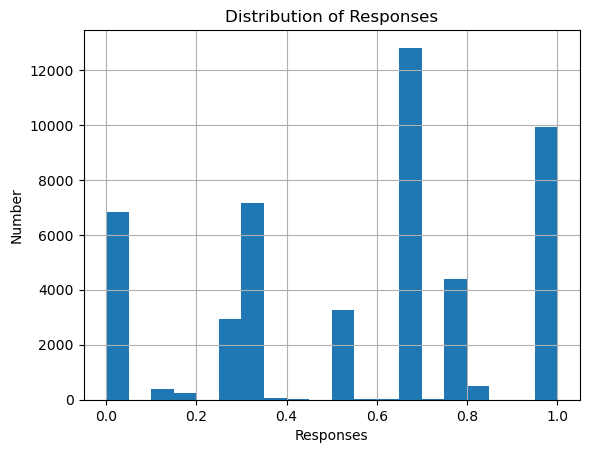

In [26]:
import matplotlib.pyplot as plt

# draw a histogram of the age column
(resc_data['correct']-1).hist(bins=20)

# add labels and title
plt.xlabel('Responses')
plt.ylabel('Number')
plt.title('Distribution of Responses')
plt.savefig('../4-figs/distribution_postcovid.png')


In [27]:
resc_data_dim_grouped_items = resc_data.groupby("item_id")["dimension_id"].nunique()
resc_data_dim_grouped_users = resc_data.groupby("item_id")["user_id"].nunique()
metadata = get_metadata(resc_data,["user_id", "item_id", "dimension_id"])
metadata['min_nb_users_logs'] = min_nb_users_logs
metadata['max_nb_categories_per_question'] = int(np.max(resc_data_dim_grouped_items))

### Compute nb of modalities per item

In [28]:
nb_modalities = get_modalities_nb(resc_data, metadata)

### Save data, concept map, metadata and nb_modalities

In [29]:
new_order = ['user_id','item_id', 'correct', 'dimension_id']
resc_data = resc_data[new_order]

In [30]:
# save selected data
resc_data.to_csv('../1-raw_data/postcovid_selected_data.csv', index=False)

In [32]:
# Convert int64 keys to str
q2k_str_keys = {str(key): value for key, value in q2k.items()}

# Convert sets to lists in the dictionary
q2k_json_serializable = {}
for key, value in q2k_str_keys.items():
    if isinstance(value, set):
        q2k_json_serializable[key] = list(value)
    else:
        q2k_json_serializable[key] = value

# Save concept map
with open('../2-preprocessed_data/postcovid_concept_map.json', 'w') as f:
    json.dump(q2k_json_serializable, f)

In [33]:
# save metadata
with open('../2-preprocessed_data/postcovid_metadata.json', 'w') as f:
    json.dump(metadata, f)

In [34]:
# save metadata
torch.save(nb_modalities,'../2-preprocessed_data/postcovid_nb_modalities.pkl')

## parse data

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from liriscat import utils
utils.setuplogger(verbose = True,log_path = "../../logs/", log_name="liriscat", os='Windows')
utils.set_seed(0)

CUDA is not available. Skipping CUDA seed setting.


In [37]:
import pandas as pd
from liriscat.dataset.preprocessing_utilities import *
resc_data = pd.read_csv('../1-raw_data/postcovid_selected_data.csv')

In [38]:
train, valid, test = split_users(resc_data, 5)

## save data

In [39]:
for i_fold, train_fold in enumerate(train):
    save_df_to_csv(train[i_fold], f'../2-preprocessed_data/postcovid_train_{i_fold}.csv')
    save_df_to_csv(valid[i_fold], f'../2-preprocessed_data/postcovid_valid_{i_fold}.csv')
    save_df_to_csv(test[i_fold], f'../2-preprocessed_data/postcovid_test_{i_fold}.csv')

## Train IMPACT model

In [40]:
from liriscat.utils import generate_eval_config
import json
from IMPACT.dataset import LoaderDataset as IMPACT_dataset
from liriscat.CDM import *
from IMPACT import model
from liriscat.dataset.preprocessing_utilities import *


folds_nb = 1
dataset_name="postcovid"

# Set all the required parameters ---------------
IMPACT_config = generate_eval_config(num_epochs=200, save_params=True, dataset_name=dataset_name, embs_path="../../embs/"+dataset_name, params_path="../../ckpt/"+dataset_name,  learning_rate=0.01885, lambda_=2e-7, batch_size=2048,valid_metric='mi_acc', pred_metrics=["mi_acc"])

concept_map = json.load(open(f'../2-preprocessed_data/{IMPACT_config["dataset_name"]}_concept_map.json', 'r'))
concept_map = {int(k): [int(x) for x in v] for k, v in concept_map.items()} #parameter
metadata = json.load(open(f'../2-preprocessed_data/{IMPACT_config["dataset_name"]}_metadata.json', 'r'))
nb_modalities = torch.load(f'../2-preprocessed_data/{IMPACT_config["dataset_name"]}_nb_modalities.pkl',weights_only=True)

# Conversion helper that builds a DataFrame with specific dtypes and returns records.
def convert_to_records(data):
    df = pd.DataFrame(data, columns={'user_id': int, 'item_id': int, 'category_id': int,'correct': float, })
    return df.to_records(index=False, column_dtypes={'user_id': int, 'item_id': int, 'correct': float, 'category_id': int})

CUDA is not available. Using CPU.


In [41]:
for i in range(folds_nb):
    # Merge the training and validation data for the current fold.
    train_valid_df = pd.concat([train[i], valid[i]])
    # Split the merged data horizontally into train and validation sets.

    quadruplet = quadruplet_format(train_valid_df)
    train_data, valid_data, test_data = split_data_vertically(quadruplet, test_prop=0.2,valid_prop=0.1,folds_nb=5)

    # Convert each split in one step using the helper.
    horizontal_train = convert_to_records(train_data[0])
    horizontal_valid = convert_to_records(valid_data[0])
    horizontal_test = convert_to_records(test_data[0])

    impact_train_data = IMPACT_dataset(horizontal_train, concept_map, metadata, nb_modalities)
    impact_valid_data = IMPACT_dataset(horizontal_valid, concept_map, metadata, nb_modalities) # <---
    impact_test_data = IMPACT_dataset(horizontal_test, concept_map, metadata, nb_modalities)

    IMPACT_config['i_fold'] = i
    algo = model.IMPACT(**IMPACT_config)
    algo.init_model(impact_train_data, impact_valid_data)
    algo.train(impact_train_data, impact_valid_data)
    print(algo.evaluate_predictions(impact_test_data))

CUDA is not available. Skipping CUDA seed setting.
[INFO 04-22] train on cpu
[INFO 04-22] -- START Training --


 60%|██████    | 121/200 [00:56<00:37,  2.13it/s]

[INFO 05-19] -- END Training --
[INFO 05-19] Params saved
{'mi_acc': 0.8395308256149292, 'preds': tensor([1., 1., 1.,  ..., 1., 1., 1.], dtype=torch.float64), 'labels': tensor([1., 1., 1.,  ..., 2., 1., 1.], dtype=torch.float64)}


In [44]:
nb_modalities

tensor([ 4,  4,  4,  4,  4,  4,  5,  4, 11,  5,  4,  5,  5,  4, 11,  5,  4,  5,
         5,  4, 11,  5,  4,  5,  5,  4,  8,  4,  5,  4,  4,  5,  5,  4,  4,  5,
         4,  4,  5,  4,  5,  4,  5,  4,  4,  4,  4,  4,  4,  5,  3,  5,  5,  4,
         4,  4,  5,  4,  5,  5,  4,  5,  4,  5,  5,  4,  5,  4,  5,  5,  4,  5,
         4,  5,  5,  4,  5,  3,  5,  5,  4,  5,  4,  5,  5,  4,  5,  4,  5,  5,
         4,  4,  5,  5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  7,  4,  4,
         7,  4,  7,  4,  7,  4,  7,  4,  7,  4,  7,  4,  7,  4,  7,  4,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  4,  5])

In [45]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from liriscat import utils
utils.set_seed(0)
from liriscat import dataset
from liriscat import selectionStrategy
from liriscat import CDM

import logging
import gc
import json
import torch
import pandas as pd
from importlib import reload
import IMPACT

import warnings
import numpy as np

gc.collect()
torch.cuda.empty_cache()

reload(utils)
reload(selectionStrategy)
reload(CDM)
reload(dataset)

config = utils.generate_eval_config(i_fold = 0,
                                    num_epochs=1,
                                    load_params=True,
                                    inner_user_lr=0.0001,
                                    esc = 'error',
                                    valid_metric= 'mi_acc',
                                    pred_metrics = ["mi_acc"],
                                    profile_metrics = ['doa'],
                                    save_params=False,
                                    n_query=5,
                                    batch_size=512)
utils.set_seed(config["seed"])

config["dataset_name"] = "postcovid"
logging.info(config["dataset_name"])
config['learning_rate'] = 0.02026
config['lambda'] = 1.2e-5
config['d_in'] = 4
config['num_responses'] = 12
#pred_metrics,df_interp = test(config)

logging.info(f'#### {config["dataset_name"]} ####')
logging.info(f'#### config : {config} ####')
config['embs_path']='../../embs/'+str(config["dataset_name"])
config['params_path']='../../ckpt/'+str(config["dataset_name"])

pred_metrics = {m:[] for m in config['pred_metrics']}
profile_metrics = {m:[] for m in config['profile_metrics']}

gc.collect()
torch.cuda.empty_cache()

# Dataset downloading for doa and rm
warnings.filterwarnings("ignore", message="invalid value encountered in divide")
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Concept map format : {question_id : [category_id1, category_id2, ...]}outside model initialization
concept_map = json.load(open(f'../2-preprocessed_data/{config["dataset_name"]}_concept_map.json', 'r'))
concept_map = {int(k): [int(x) for x in v] for k, v in concept_map.items()}

## Metadata map format : {"num_user_id": ..., "num_item_id": ..., "num_dimension_id": ...}
metadata = json.load(open(f'../2-preprocessed_data/{config["dataset_name"]}_metadata.json', 'r'))

i_fold = 0
## Dataframe columns : (user_id, question_id, response, category_id)
train_df = pd.read_csv(
    f'../2-preprocessed_data/{config["dataset_name"]}_train_{i_fold}.csv',
    encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                             "dimension_id": int})
valid_df = pd.read_csv(
    f'../2-preprocessed_data/{config["dataset_name"]}_valid_{i_fold}.csv',
    encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                             "dimension_id": int})
test_df = pd.read_csv(
    f'../2-preprocessed_data/{config["dataset_name"]}_test_{i_fold}.csv',
    encoding='utf-8', dtype={'student_id': int, 'item_id': int, "correct": float,
                                                             "dimension_id": int})
train_data = dataset.CATDataset(train_df, concept_map, metadata, config, nb_modalities)
valid_data = dataset.EvalDataset(valid_df, concept_map, metadata, config, nb_modalities)
test_data = dataset.EvalDataset(test_df, concept_map, metadata, config, nb_modalities)

S = selectionStrategy.Random(metadata,**config)

CUDA is not available. Skipping CUDA seed setting.
CUDA is not available. Using CPU.
CUDA is not available. Skipping CUDA seed setting.
[INFO 34-46] postcovid
[INFO 34-46] #### postcovid ####
[INFO 34-46] #### config : {'seed': 0, 'dataset_name': 'postcovid', 'load_params': True, 'save_params': False, 'embs_path': '../embs/', 'params_path': '../ckpt/', 'early_stopping': True, 'esc': 'error', 'verbose_early_stopping': False, 'disable_tqdm': False, 'valid_metric': 'mi_acc', 'learning_rate': 0.02026, 'batch_size': 512, 'valid_batch_size': 10000, 'num_epochs': 1, 'eval_freq': 1, 'patience': 30, 'device': device(type='cpu'), 'lambda': 1.2e-05, 'tensorboard': False, 'flush_freq': True, 'pred_metrics': ['mi_acc'], 'profile_metrics': ['doa'], 'num_responses': 12, 'low_mem': False, 'n_query': 5, 'CDM': 'impact', 'i_fold': 0, 'num_inner_users_epochs': 10, 'num_inner_epochs': 10, 'inner_lr': 0.0001, 'inner_user_lr': 0.0001, 'd_in': 4} ####
CUDA is not available. Skipping CUDA seed setting.
CUDA i

In [46]:
S.init_models(train_data, valid_data)

compiling CDM model
compiling selection model


In [47]:
S.evaluate_test(test_data)

/home/mbensafi/miniconda3/envs/IMPACT/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
  0%|          | 0/5 [00:01<?, ?it/s]


BackendCompilerFailed: backend='inductor' raised:
InvalidCxxCompiler: No working C++ compiler found in torch._inductor.config.cpp.cxx: (None, 'g++')

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


In [5]:
torch.sum(S.CDM.model.R!=0)

tensor(0, device='cuda:0')